### Preparing tensorflow and libraries 

In [2]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-07 18:58:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-07 18:58:20 (92.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import*

In [4]:
import itertools

In [5]:
unzip_data("/content/drive/MyDrive/Chest X_Ray/archive.zip")

## Preparing the Data

In [6]:
## Setting up the directoris 
train_dir = "/content/chest_xray/train/"
test_dir = "/content/chest_xray/test/"
validation_dir = "/content/chest_xray/val/"

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img, cmap = "gray")
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (1224, 1696)


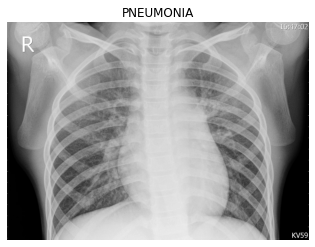

In [8]:
img = view_random_image(target_dir = train_dir, target_class = "PNEUMONIA")
img = tf.constant(img)

In [9]:
## Setting up the data

## Set the image size 
IMG_SIZE = (224, 224)

print("Training Images:")
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = "binary",
                                                                 color_mode = "grayscale",
                                                                 batch_size = 32)

print("Testing Images:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = "binary",
                                                                color_mode = "grayscale",
                                                                 batch_size = 32)

print("Validation Images:")
val_data = tf.keras.preprocessing.image_dataset_from_directory(directory = validation_dir,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = "binary",
                                                                 color_mode = "grayscale",
                                                                 batch_size = 32)

Training Images:
Found 5216 files belonging to 2 classes.
Testing Images:
Found 624 files belonging to 2 classes.
Validation Images:
Found 16 files belonging to 2 classes.


### Setting up the data Augmentation Layer 

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  ##preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## Setting up the model

In [11]:
## Using the model EfficientNetB1 for the first experiment with all the layers trainable 

base_model = tf.keras.applications.EfficientNetB1(include_top = False)
base_model.trainable = True 

27033600/27018416 [==============================] - 1s 0us/step


In [ ]:
## Checking if the layers are trainable 

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.trainable)

## Building the Model

In [13]:
## Inspecting the train_data
train_data

<BatchDataset shapes: ((None, 224, 224, 1), (None, 1)), types: (tf.float32, tf.float32)>

In [14]:
## Creating the model 
inputs = tf.keras.layers.Input(shape = (224, 224, 1), name = "Input_Layer")
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = data_augmentation(inputs)
x = tf.keras.layers.Conv2D(3,(3,3),padding='same')(x)
x = base_model(x)
x = tf.keras.layers.GlobalMaxPooling2D(name = "global_max")(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)
model_0 = tf.keras.Model(inputs, outputs)

## Compiling the model
model_0.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

### Setting up the callbacks

In [15]:
## Setting up callbacks
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.25, # multiply the learning rate by 0.2 (reduce by 4x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Fitting the model

In [16]:
## Check the summary
for no, layers in enumerate(model_0.layers):
  print(no, layers.trainable)

0 True
1 True
2 True
3 True
4 True
5 True


In [17]:
history_0 = model_0.fit(train_data,
                        epochs = 100,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [early_stopping, reduce_lr])

Epoch 1/100
163/163 [==============================] - 232s 1s/step - loss: 0.3658 - accuracy: 0.8765 - val_loss: 0.5648 - val_accuracy: 0.7625 - lr: 1.0000e-04
Epoch 2/100
163/163 [==============================] - 173s 1s/step - loss: 0.1670 - accuracy: 0.9360 - val_loss: 0.4777 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 3/100
163/163 [==============================] - 165s 1s/step - loss: 0.1433 - accuracy: 0.9479 - val_loss: 0.4995 - val_accuracy: 0.8313 - lr: 1.0000e-04
Epoch 4/100
163/163 [==============================] - 157s 954ms/step - loss: 0.1259 - accuracy: 0.9572 - val_loss: 0.3700 - val_accuracy: 0.8938 - lr: 1.0000e-04
Epoch 5/100
163/163 [==============================] - 146s 891ms/step - loss: 0.1024 - accuracy: 0.9607 - val_loss: 0.4737 - val_accuracy: 0.8687 - lr: 1.0000e-04
Epoch 6/100
163/163 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9670
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
163/163 [===

In [18]:
model_0.evaluate(test_data)

20/20 [==============================] - 6s 227ms/step - loss: 0.4734 - accuracy: 0.8654


[0.47343477606773376, 0.8653846383094788]

In [19]:
model_0.evaluate(val_data)

1/1 [==============================] - 0s 201ms/step - loss: 0.3947 - accuracy: 0.8750


[0.3947019577026367, 0.875]

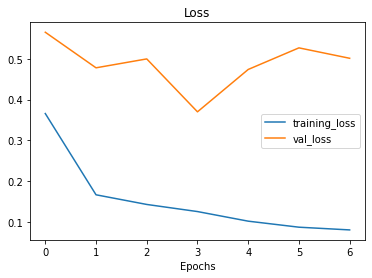

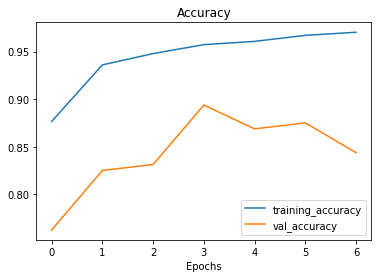

In [20]:
plot_loss_curves(history_0)